In [37]:
import numpy as np
import scipy


def cauchy_point(B,g,Delta):
    ng = np.linalg.norm(g)
    ps = -g*Delta/ng
    aux = np.dot(g,B @ g)
    if( aux <= 0 ):
        p = ps
    else:
        a = np.minimum(ng**3/(Delta*aux),1)
        p = ps*a
    return p


def _trust_region(func,grad,hess,x,method='newton',max_iter=200,tol=1e-6):
    # parameters for trust region
    Delta_max = 5 # the max trust-region radius
    Delta_min = 1e-12 # the minimal trust-region radius
    Delta = 1 # the initial radius
    eta = 0.1 # step rejection parameter
    subproblem_iter_max = 5 # the max # of iteration for quadratic subproblems
    tol_sub = 1e-1 # relative tolerance for the subproblem
    rho_good = 0.75 # if rho > rho_good, increase the trust-region radius
    rho_bad = 0.25 # if rho < rho_bad, decrease the trust-region radius
    # initialization
    f = func(x)
    g = grad(x)
    norm_g = np.linalg.norm(g)
    print("Initially, f = ",f,", ||grad f|| = ",norm_g)

    fvals = []
    fvals.append(f)
    ngvals = []
    ngvals.append(norm_g)
    Delta = 1 # the initial trust region radius
    I = np.eye(np.size(x),dtype = float)
    iter = 1
    if method == "bfgs":
        B = I
    # the main trust-region cycle
    while (norm_g > tol and iter < max_iter):
        # solve the constrained minimization problem
        if method == "newton":
            B = hess(x)
        flag_boundary = 0
        # check if B is SPD
        eval_min = np.amin(np.real(scipy.linalg.eig(B, b=None, left=False, right=False)))
        j_sub = 0
        if( eval_min > 0 ): # B is SPD: B = R'*R, R'*R*p = -g
            p = scipy.linalg.solve(B,-g)
            p_norm = np.linalg.norm(p)
            if( p_norm > Delta ): # else: we are done with solbing the subproblem
                flag_boundary = 1
        else:
            flag_boundary = 1
        if( flag_boundary == 1 ): # solution lies on the boundary
            lam_min = np.maximum(-eval_min,0.0)
            lam = lam_min + 1
            R = scipy.linalg.cholesky(B+lam*I,lower = False)
            flag_subproblem_success = 0
            while( j_sub < subproblem_iter_max ):
                j_sub = j_sub + 1
                p = scipy.linalg.solve_triangular(np.transpose(R),-g,lower = True)
                p = scipy.linalg.solve_triangular(R,p,lower = False)
                p_norm = np.linalg.norm(p)
                dd = np.absolute(p_norm - Delta)
                if( dd < tol_sub*Delta ):
                    flag_subproblem_success = 1
                    break
                q = scipy.linalg.solve_triangular(np.transpose(R),p,lower = True)
                q_norm = np.linalg.norm(q)
                dlam = ((p_norm/q_norm)**2)*(p_norm - Delta)/Delta
                lam_new = lam + dlam
                if (lam_new > lam_min):
                    lam = lam_new
                else:
                    lam = 0.5*(lam + lam_min)
                R = scipy.linalg.cholesky(B+lam*I,lower = False)
            if( flag_subproblem_success == 0 ):
                p = cauchy_point(B,g,Delta)
        # assess the progress
        xnew = x + p
        fnew = func(xnew)
        gnew = grad(xnew)
        mnew = f + np.dot(g,p) + 0.5*np.dot(p,B @ p)
        rho = (f - fnew)/(f - mnew+1e-14)
        # adjust the trust region
        if( rho < rho_bad ):
            Delta = np.maximum(0.25*Delta,Delta_min)
        elif(  rho > rho_good and flag_boundary == 1 ):
            Delta = np.minimum(Delta_max,2*Delta)
        # accept or reject step
        if( rho > eta ):  # accept step
            x = xnew
            f = fnew
            g = gnew
            norm_g = np.linalg.norm(g)
            # print(f'Accept: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
        else:
            pass
            # print(f'Reject: iter {iter}: f = {f:.10f}, |df| = {norm_g:.4e}, rho = {rho:.4e}, Delta = {Delta:.4e}, j_sub = {j_sub}')
        fvals.append(f)
        ngvals.append(norm_g)
        iter = iter + 1
    return x,fvals,ngvals

def _dogleg_subproblem(B,g,Delta):
    return

def _exact_subproblem(B,g,Delta):
    return


In [34]:
import numpy as np
import scipy.linalg

def _trust_region(func, grad, hess, x, max_iter=200, tol=1e-6, use_bfgs=False):
    # Parameters for trust region
    Delta_max = 5  # max trust-region radius
    Delta_min = 1e-12  # min trust-region radius
    Delta = 1  # initial radius
    eta = 0.1  # step rejection parameter
    subproblem_iter_max = 5  # max # of iterations for quadratic subproblems
    tol_sub = 1e-1  # relative tolerance for the subproblem
    rho_good = 0.75  # if rho > rho_good, increase the trust-region radius
    rho_bad = 0.25  # if rho < rho_bad, decrease the trust-region radius

    # Initialization
    f = func(x)
    g = grad(x)
    norm_g = np.linalg.norm(g)
    print("Initially, f = ", f, ", ||grad f|| = ", norm_g)
    
    fvals = [f]
    ngvals = [norm_g]
    I = np.eye(np.size(x), dtype=float)
    iter = 1
    B = hess(x) if not use_bfgs else I  # Use identity if using BFGS

    while norm_g > tol and iter < max_iter:
        # Update approximate Hessian using BFGS
        if use_bfgs and iter > 1:
            s = x - x_prev
            y = g - g_prev
            ys = np.dot(y, s)
            if ys > 1e-10:  # Update if condition is satisfied
                B = B + np.outer(y, y) / ys - B @ np.outer(s, s) @ B / (s @ B @ s)

        # Determine the step direction using either Newton or dogleg method
        if not use_bfgs:
            # Regular trust-region method with exact Hessian
            p, flag_boundary = _trust_region_subproblem(B, g, Delta)
        else:
            # Dogleg method for BFGS approximation
            p = _dogleg_subproblem(g, B, Delta)
            flag_boundary = np.linalg.norm(p) > Delta  # Check if step is on boundary

        # Compute new values and update trust region
        xnew = x + p
        fnew = func(xnew)
        gnew = grad(xnew)
        mnew = f + np.dot(g, p) + 0.5 * np.dot(p, B @ p)
        rho = (f - fnew) / (f - mnew + 1e-14)

        # Adjust the trust region radius
        if rho < rho_bad:
            Delta = max(0.25 * Delta, Delta_min)
        elif rho > rho_good and flag_boundary:
            Delta = min(Delta_max, 2 * Delta)

        # Accept or reject the step
        if rho > eta:  # Accept the step
            x_prev, g_prev = x, g
            x, f, g = xnew, fnew, gnew
            norm_g = np.linalg.norm(g)

        fvals.append(f)
        ngvals.append(norm_g)
        iter += 1

    return x, fvals, ngvals


def _trust_region_subproblem(B, g, Delta):
    """
    Solves the trust region subproblem using the Cholesky factorization.
    """
    flag_boundary = 0
    eval_min = np.amin(np.real(scipy.linalg.eigvals(B)))
    if eval_min > 0:  # B is SPD
        p = scipy.linalg.solve(B, -g)
        if np.linalg.norm(p) > Delta:
            flag_boundary = 1
    else:
        flag_boundary = 1
    if flag_boundary == 1:
        p = _cauchy_point(B, g, Delta)
    return p, flag_boundary


def _dogleg_subproblem(g, B, Delta):
    """
    Dogleg method to solve the trust-region subproblem for BFGS.
    """
    # Compute the Cauchy point (steepest descent direction scaled to the boundary)
    p_u = - (Delta / np.linalg.norm(g)) * g if np.linalg.norm(g) > 1e-10 else np.zeros_like(g)
    
    # Compute the Newton point (approximate Hessian inverse step)
    p_b = np.linalg.solve(B, -g)
    
    # Compute dogleg path within trust region boundary
    if np.linalg.norm(p_b) <= Delta:
        return p_b
    else:
        # Compute the tau value for dogleg interpolation on boundary
        pu_norm, pb_norm = np.linalg.norm(p_u), np.linalg.norm(p_b - p_u)
        tau = np.roots([pb_norm**2, 2 * np.dot(p_u, p_b - p_u), pu_norm**2 - Delta**2])
        tau = np.max(tau[tau >= 0])  # Choose positive tau value
        return p_u + tau * (p_b - p_u)


def _cauchy_point(B, g, Delta):
    """
    Computes the Cauchy point for the trust-region problem.
    """
    Bg = B @ g
    tau = min(Delta / np.linalg.norm(g), np.dot(g, g) / np.dot(g, Bg))
    return -tau * g


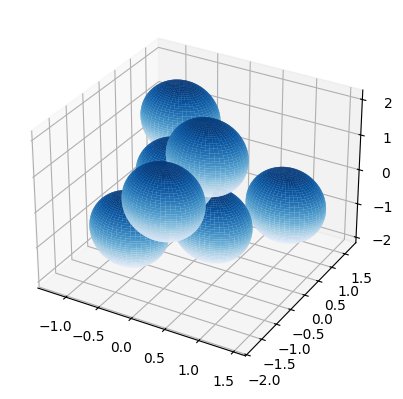

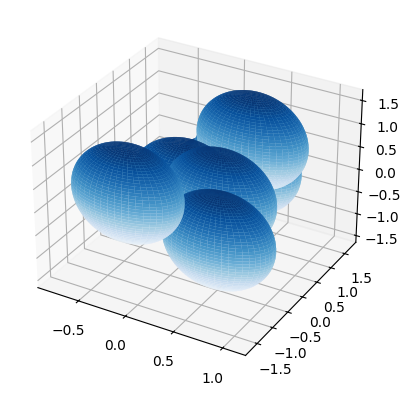

LJpot =  777897.3087582686


In [29]:
from LJhelpers import *
Na = 7 #the number of atoms
rstar = 2**(1/6) # argument of the minimum of the Lennard-Jones pair potential V(r) = r^(-12) - r^(-6)
tol = 1e-9 # stop iterations when ||grad f|| < tol
iter_max = 1000 # the maximal number of iterations
draw_flag = 1 # if draw_flag = 1, draw configuration at every iteration
# parameters for backtracking line search
c = 0.1;
rho = 0.9;

model = 0
if( model > 0):
    Na = 7
xyz = initial_configuration(model,Na,rstar)
drawconf(xyz,0.5*rstar);

x0 = remove_rotations_translations(xyz)
drawconf(LJvector2array(x0),0.5*rstar)
print("LJpot = ",LJpot(x0))
# print(LJhess(x))



In [38]:
import matplotlib.pyplot as plt

fvalss = {}
ngvalss = {}

for direction, method in [(0, "SD"), (1, "Newton"), (2, "BFGS")]:
    fvalss[method] = {}
    ngvalss[method] = {}
    xyzs = [initial_configuration(model,Na,rstar) for model in range(1,5)] 
    for _ in range(10):
        xyzs.append(initial_configuration(5,Na,rstar))
    confs = list(range(1,5))+[f'rand{i}' for i in range(10)]

    x0s = [remove_rotations_translations(xyz) for xyz in xyzs]
    for conf,x0 in zip(confs,x0s):
        xopt,fvals,ngvals = _trust_region(LJpot, LJgrad, LJhess, x0,max_iter=1000)
        print("Optimization result:", xopt)
        fvalss[method][conf] = fvals
        ngvalss[method][conf] = ngvals

Initially, f =  -11.517662869490488 , ||grad f|| =  16.468632904952266
Optimization result: [ 1.12408793e+00  1.47145021e+00  1.06907115e+00  5.62043967e-01
  1.72979346e+00 -3.70688349e-16 -3.47362275e-01  1.06907115e+00
 -1.95545001e-16  5.62043967e-01  7.73587155e-01  5.73870169e-01
  5.62043967e-01  7.73587155e-01 -5.73870169e-01]
Initially, f =  -15.921231995884773 , ||grad f|| =  2.1196800775302633
Optimization result: [ 1.11959051e+00  1.11850571e+00  1.11536611e+00  1.08479969e-03
  1.11536611e+00  3.03196874e-11  5.59795257e-01  5.61371003e-01
  7.90553468e-01  5.59795257e-01  5.55082963e-01 -7.89021494e-01
  5.59795257e-01 -5.56644359e-01  7.91666544e-01]
Initially, f =  -15.581469160072078 , ||grad f|| =  1.4608366392938117
Optimization result: [ 1.1187935   0.55939675  0.96890359  0.55939675 -0.74773545  0.61550284
  1.48665302  0.85831952  0.61550284 -0.36785952  0.85831952  0.61550284
  0.55939675  0.32296786  0.92200413]
Initially, f =  -15.522210169999571 , ||grad f|| =

SD
Newton
BFGS


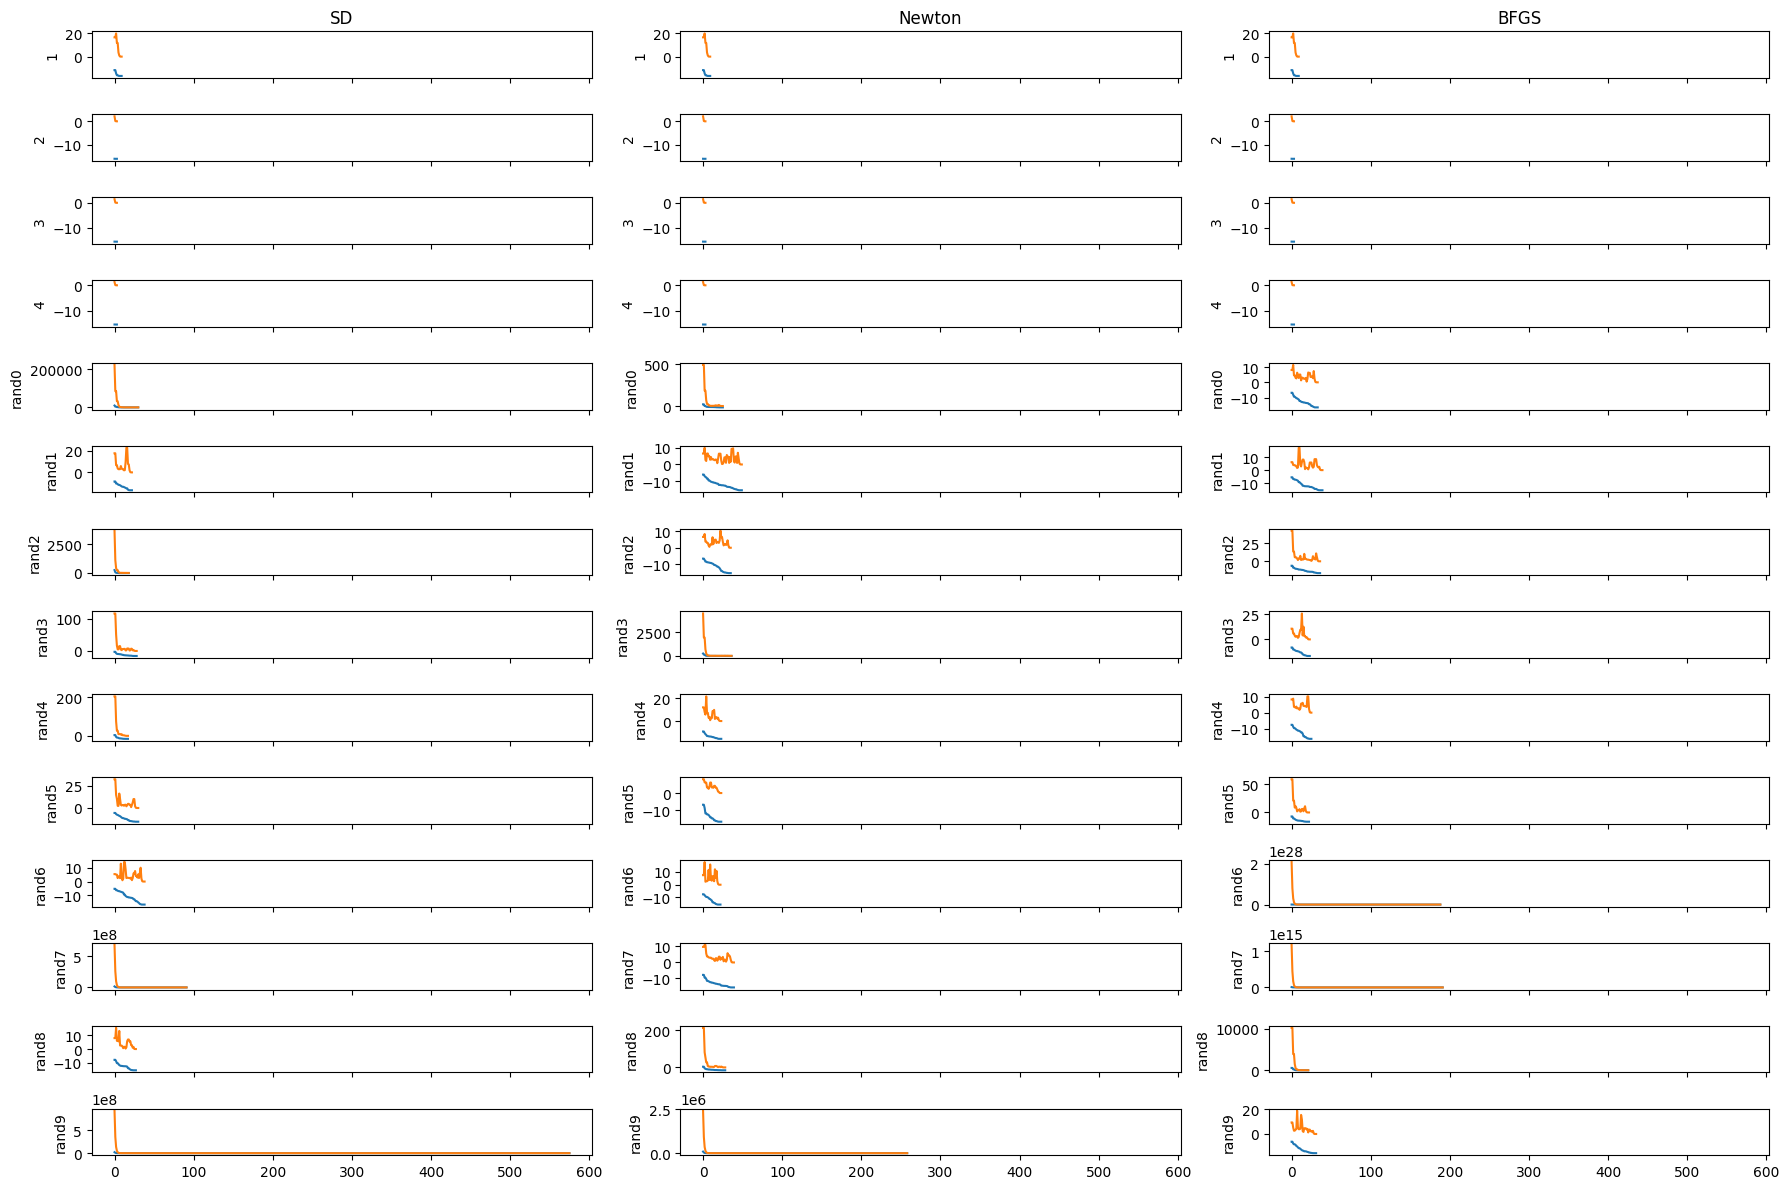

In [39]:
fig,ax = plt.subplots(len(confs),3,figsize = (18,12), sharex=True)
for i,method in enumerate(list(fvalss.keys())):
    print(method)
    ax[0,i].set_title(f'{method}')
    for j,conf in enumerate(list(fvalss[method].keys())):
        
        # print(conf)
        ax[j,i].set_ylabel(f'{conf}')
        ax[j,i].plot(fvalss[method][conf])
        ax[j,i].plot(ngvalss[method][conf])

plt.tight_layout()
plt.show()
#         ax[i].plot(fvals)
# ax[0].plot(fvals)
# ax[1].plot(ngvals)


In [26]:
import numpy as np

# Define the quadratic function, gradient, and Hessian
a = 1
b = 100

# Define the Rosenbrock function, its gradient, and Hessian
def func(x):
    return (a - x[0]) ** 2 + b * (x[1] - x[0] ** 2) ** 2

def grad(x):
    df_dx = -2 * (a - x[0]) - 4 * b * x[0] * (x[1] - x[0] ** 2)
    df_dy = 2 * b * (x[1] - x[0] ** 2)
    return np.array([df_dx, df_dy])

def hess(x):
    d2f_dx2 = 2 - 4 * b * (x[1] - x[0] ** 2) + 8 * b * x[0] ** 2
    d2f_dxdy = -4 * b * x[0]
    d2f_dy2 = 2 * b
    return np.array([[d2f_dx2, d2f_dxdy],
                     [d2f_dxdy, d2f_dy2]])

x0 = np.array([-1.2, 1.2])

x,fvals,ngvals = _trust_region(func,grad,hess,x0)

Initially, f =  10.600000000000001 , ||grad f|| =  128.87265031805623
Accept: iter 1: f = 4.6448711621, |df| = 5.2571e+00, rho = 1.0164e+00, Delta = 1.0000e+00, j_sub = 0
Reject: iter 2: f = 4.6448711621, |df| = 5.2571e+00, rho = -5.4456e-01, Delta = 2.5000e-01, j_sub = 2
Accept: iter 3: f = 4.2134145625, |df| = 5.5172e+00, rho = 1.0201e+00, Delta = 5.0000e-01, j_sub = 2
Accept: iter 4: f = 3.5330443810, |df| = 1.9245e+01, rho = 8.3550e-01, Delta = 1.0000e+00, j_sub = 2
Accept: iter 5: f = 2.8302178254, |df| = 1.5471e+01, rho = 1.3167e+00, Delta = 1.0000e+00, j_sub = 0
Accept: iter 6: f = 2.2210858945, |df| = 1.1260e+01, rho = 1.3344e+00, Delta = 1.0000e+00, j_sub = 0
Accept: iter 7: f = 1.7212977116, |df| = 9.3725e+00, rho = 1.2956e+00, Delta = 1.0000e+00, j_sub = 0
Accept: iter 8: f = 1.2864686086, |df| = 5.9731e+00, rho = 1.3489e+00, Delta = 1.0000e+00, j_sub = 0
Accept: iter 9: f = 0.9657901333, |df| = 6.8565e+00, rho = 1.2030e+00, Delta = 1.0000e+00, j_sub = 0
Accept: iter 10: f =

SD
Newton
BFGS


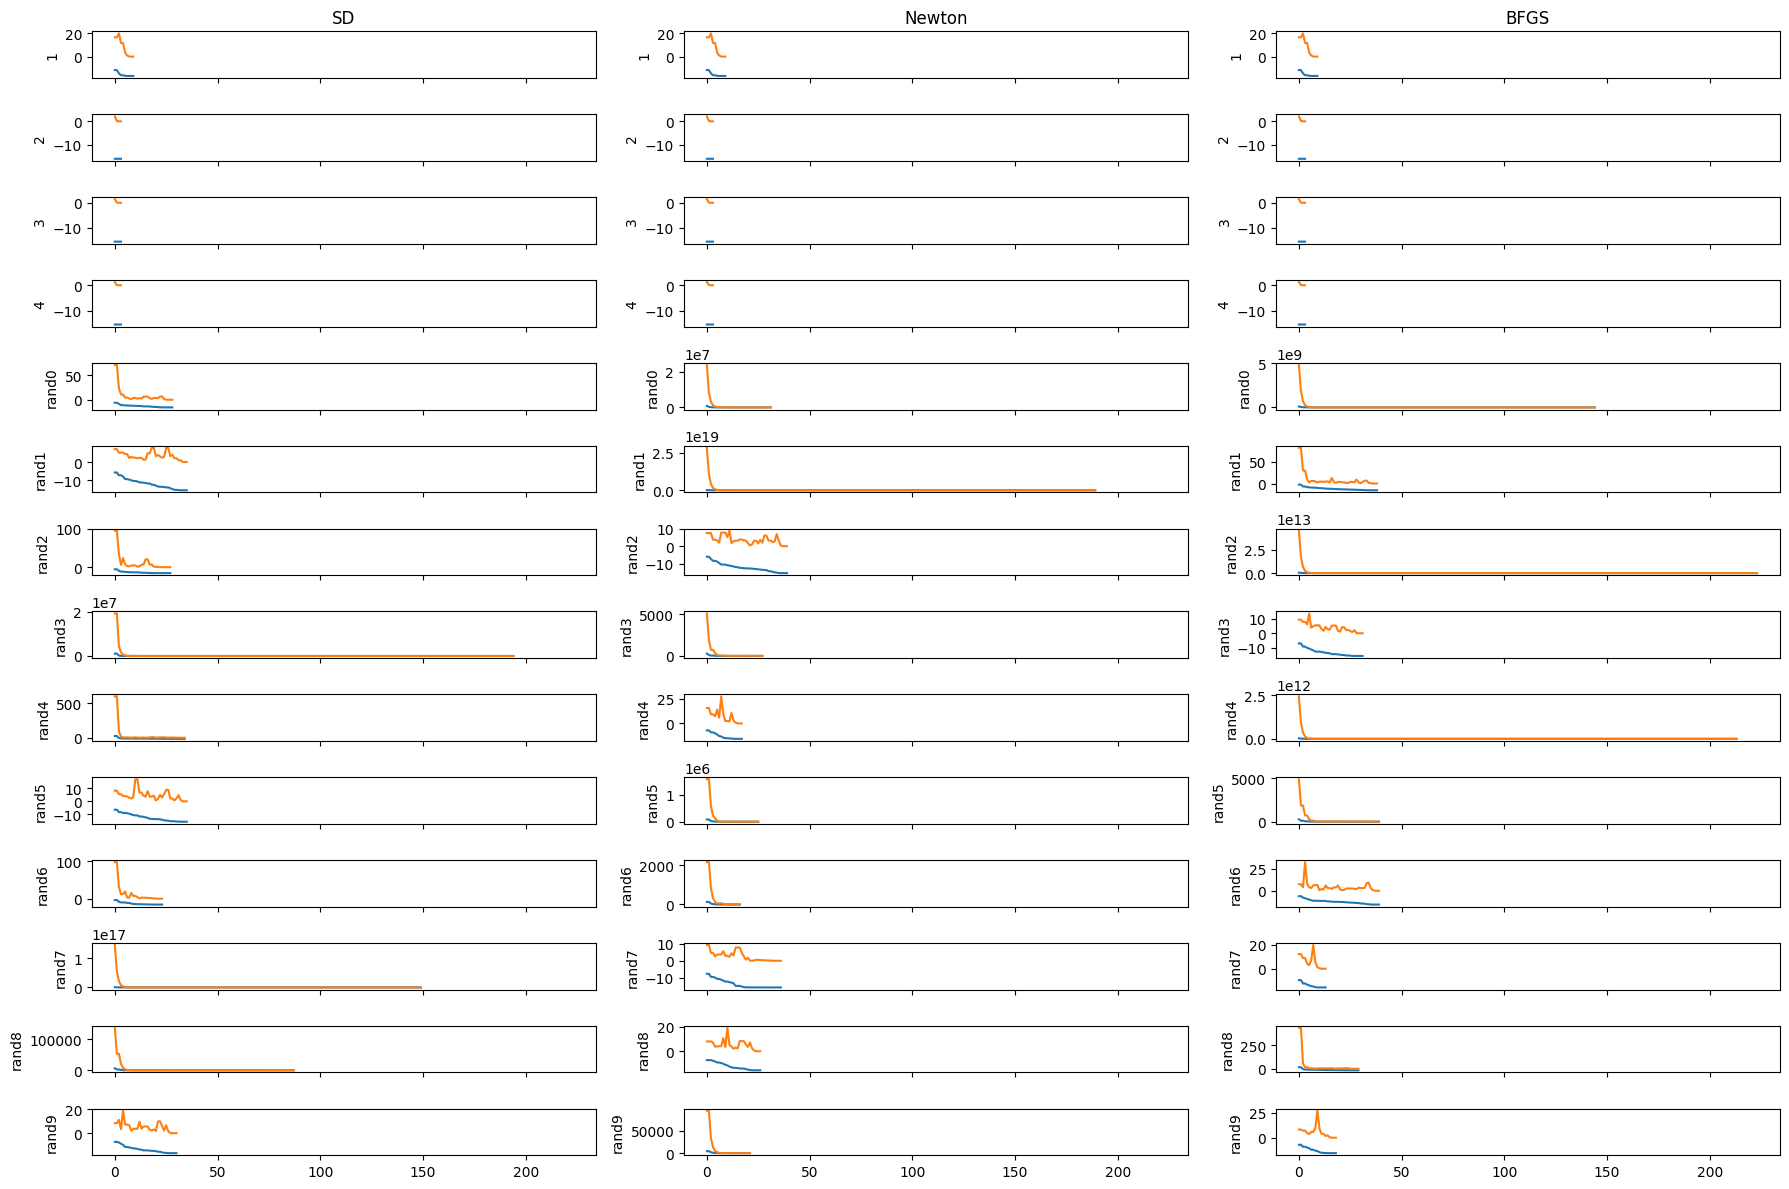

In [27]:
x

array([1., 1.])